<a href="https://colab.research.google.com/github/ABD-01/MNIST/blob/main/MNIST_Using_Multi_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install idx2numpy

  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-cp36-none-any.whl size=7905 sha256=758be74ed7ac537f5a5290ed3d24e0cfd9e1890b7f804101e0ea930814d71cdd
  Stored in directory: /root/.cache/pip/wheels/7a/c1/da/284ce80a748fab898b8d1fa95468a386e7cf3b81da18511f9d
Successfully built idx2numpy


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import idx2numpy
from tqdm import tqdm
import os

In [5]:
test_images = idx2numpy.convert_from_file('/content/drive/MyDrive/Colab Notebooks/t10k-images.idx3-ubyte')
test_labels = idx2numpy.convert_from_file('/content/drive/MyDrive/Colab Notebooks/t10k-labels.idx1-ubyte')
train_images = idx2numpy.convert_from_file('/content/drive/MyDrive/Colab Notebooks/train-images.idx3-ubyte')
train_labels = idx2numpy.convert_from_file('/content/drive/MyDrive/Colab Notebooks/train-labels.idx1-ubyte')

In [6]:
print(test_images.shape)
print(test_labels.shape)
print(train_images.shape)
print(train_labels.shape)

(10000, 28, 28)
(10000,)
(60000, 28, 28)
(60000,)


In [7]:
train_images_flat=train_images.reshape(train_images.shape[0], -1).T
test_images_flat=test_images.reshape(test_images.shape[0], -1).T

In [8]:
m = train_images_flat.shape[1]
m_test = test_images_flat.shape[1]
print(f"Train Examples(m)={m}")
print(f"Test Examples(m_test)={m_test}")
X = train_images_flat/255
X_test = test_images_flat/255
print('X.shape=',X.shape)
print('X_test.shape=',X_test.shape)

Train Examples(m)=60000
Test Examples(m_test)=10000
X.shape= (784, 60000)
X_test.shape= (784, 10000)


In [9]:
def one_hot(row_vector, no_classes):
    one_hot_vector = np.eye(no_classes)[row_vector.reshape(-1)]
    return one_hot_vector.T

In [10]:
C = train_labels.max()+1
print(f"No. of Classes={C}")
Y_hot = one_hot(train_labels,no_classes=C)
Y_test_hot = one_hot(test_labels,no_classes=C)
print('Y_hot.shape=',Y_hot.shape) #Y_hot.shape is (C,m)
print('Y_test_hot.shape=',Y_test_hot.shape) #Y_hot.shape is (C,m)

No. of Classes=10
Y_hot.shape= (10, 60000)
Y_test_hot.shape= (10, 10000)


In [11]:
no_of_layers = 4
nodes = [X.shape[0], 512, 128, 32, 10]   # 4 layers with size 512, 128, 32, 10
nodes

[784, 512, 128, 32, 10]

In [12]:
def initialize():
  global WW, bb
  WW = {}
  bb = {}
  for l in range(1,no_of_layers+1):
    WW['W'+str(l)] = np.random.randn(nodes[l], nodes[l-1])*np.sqrt(2/nodes[l-1])
    bb['b'+str(l)] = np.zeros((nodes[l],1))

In [13]:
list(range(1,no_of_layers+1))

[1, 2, 3, 4]

In [14]:
initialize()

In [15]:
WW['W1'].shape, WW['W2'].shape,WW['W3'].shape, WW['W4'].shape

((512, 784), (128, 512), (32, 128), (10, 32))

In [16]:
bb['b1'].shape, bb['b2'].shape,bb['b3'].shape, bb['b4'].shape

((512, 1), (128, 1), (32, 1), (10, 1))

In [17]:
def relu(z):
  a = np.maximum(0,z)
  return a

def softmax(z):
  t = np.exp(z)
  a = t / (np.sum(t, keepdims=True, axis=0))
  return a  #+ 1e-08

def derivative_relu(da,z):
  dz = np.array(da, copy=True)
  dz[z <= 0] = 0
  return dz


In [18]:
def forward():
  global ZZ, AA
  ZZ={}
  AA={}
  AA['A'+str(0)] = X
  for l in range(1,no_of_layers):
    ZZ['Z'+str(l)] = np.dot(WW['W'+str(l)], AA['A'+str(l-1)]) +  bb['b'+str(l)]
    AA['A'+str(l)] = relu(ZZ['Z'+str(l)])

  ZZ['Z'+str(no_of_layers)] = np.dot(WW['W'+str(no_of_layers)], AA['A'+str(no_of_layers-1)]) +  bb['b'+str(no_of_layers)]
  AA['A'+str(no_of_layers)] = softmax(ZZ['Z'+str(no_of_layers)])

In [19]:
forward()

In [20]:
[(z[0],z[1].shape) for z in ZZ.items()], [(a[0],a[1].shape) for a in AA.items()]

([('Z1', (512, 60000)),
  ('Z2', (128, 60000)),
  ('Z3', (32, 60000)),
  ('Z4', (10, 60000))],
 [('A0', (784, 60000)),
  ('A1', (512, 60000)),
  ('A2', (128, 60000)),
  ('A3', (32, 60000)),
  ('A4', (10, 60000))])

In [21]:
def cost():
  global L,J
  L = -np.sum(Y_hot*np.log(AA['A'+str(no_of_layers)]), keepdims=True, axis=0)
  J = np.sum(L, keepdims=True, axis=1)*(1/m)

In [22]:
cost()

In [23]:
L.shape , J.shape

((1, 60000), (1, 1))

In [41]:
def backward():
  global dAA, dZZ, dWW, dbb
  dAA = {}
  dZZ = {}
  dWW = {}
  dbb = {}
  dZZ['dZ'+str(no_of_layers)] = AA['A'+str(no_of_layers)] - Y_hot
  dWW['dW'+str(no_of_layers)] = np.dot(dZZ['dZ'+str(no_of_layers)], AA['A'+str(no_of_layers-1)].T) / m
  dbb['db'+str(no_of_layers)] = np.sum(dZZ['dZ'+str(no_of_layers)], axis=1, keepdims=True) / m
  dAA['dA'+str(no_of_layers-1)] = np.dot(WW['W'+str(no_of_layers)].T, dZZ['dZ'+str(no_of_layers)])

  for l in range(no_of_layers-1,0,-1):
    dZZ['dZ'+str(l)] = np.multiply(dAA['dA'+str(l)] , derivative_relu(dAA['dA'+str(l)], ZZ['Z'+str(l)]))
    dWW['dW'+str(l)] = np.dot(dZZ['dZ'+str(l)], AA['A'+str(l-1)].T) / m
    dbb['db'+str(l)] = np.sum(dZZ['dZ'+str(l)], axis=1, keepdims=True) / m
    dAA['dA'+str(l-1)] = np.dot(WW['W'+str(l)].T, dZZ['dZ'+str(l)])

In [42]:
backward()

In [43]:
[(dz[0],dz[1].shape) for dz in dZZ.items()], [(da[0],da[1].shape) for da in dAA.items()]

([('dZ4', (10, 60000)),
  ('dZ3', (32, 60000)),
  ('dZ2', (128, 60000)),
  ('dZ1', (512, 60000))],
 [('dA3', (32, 60000)),
  ('dA2', (128, 60000)),
  ('dA1', (512, 60000)),
  ('dA0', (784, 60000))])

In [44]:
[(dw[0],dw[1].shape) for dw in dWW.items()], [(db[0],db[1].shape) for db in dbb.items()]

([('dW4', (10, 32)),
  ('dW3', (32, 128)),
  ('dW2', (128, 512)),
  ('dW1', (512, 784))],
 [('db4', (10, 1)), ('db3', (32, 1)), ('db2', (128, 1)), ('db1', (512, 1))])

In [60]:
initialize()

In [61]:
#optimise
alpha = 0.09
iterations = 40
global costs
costs=[]
for i in range(iterations):
    forward()
    if i%1 ==0:
      cost()
      costs.append(J)
      print(f'Cost at {i}th loop = {J}')
    backward()
    for l in range(1,no_of_layers+1):
      WW['W'+str(l)] = WW['W'+str(l)] - (alpha*dWW['dW'+str(l)])
      bb['b'+str(l)] = bb['b'+str(l)] - (alpha*dbb['db'+str(l)])

Cost at 0th loop = [[2.42494645]]
Cost at 1th loop = [[2.40419697]]
Cost at 2th loop = [[2.38842501]]
Cost at 3th loop = [[2.37624161]]
Cost at 4th loop = [[2.36675428]]
Cost at 5th loop = [[2.35933497]]
Cost at 6th loop = [[2.35354729]]
Cost at 7th loop = [[2.34897766]]
Cost at 8th loop = [[2.34531877]]
Cost at 9th loop = [[2.34234931]]
Cost at 10th loop = [[2.33987994]]
Cost at 11th loop = [[2.33775244]]
Cost at 12th loop = [[2.33585656]]
Cost at 13th loop = [[2.33414256]]
Cost at 14th loop = [[2.33256585]]
Cost at 15th loop = [[2.33109545]]
Cost at 16th loop = [[2.32971266]]
Cost at 17th loop = [[2.32841092]]
Cost at 18th loop = [[2.32718378]]
Cost at 19th loop = [[2.32603416]]
Cost at 20th loop = [[2.32495341]]
Cost at 21th loop = [[2.32394311]]
Cost at 22th loop = [[2.32299338]]
Cost at 23th loop = [[2.32209523]]
Cost at 24th loop = [[2.32124441]]
Cost at 25th loop = [[2.32044462]]
Cost at 26th loop = [[2.31969276]]
Cost at 27th loop = [[2.31898585]]
Cost at 28th loop = [[2.318320

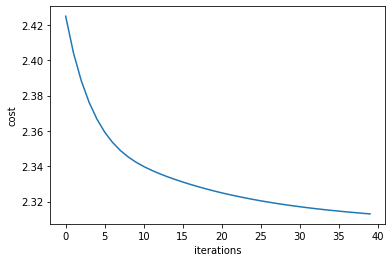

40

In [62]:
plt.plot(np.arange(0,40,1), np.array(costs).reshape(len(costs),1))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show()
len(costs)

In [66]:
a = np.abs(AA['A4']- Y_hot)
print(f'Accuracy : {100 - np.mean(a)*100} on Train Set')

Accuracy : 81.98320546987658 on Train Set
